In [1]:
import numpy as np
import os, re
import json
import h5py as h5
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import time
import matplotlib.pyplot as plt

import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions

physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    print("Invalid device or cannot modify virtual devices once initialized.")
    pass

In [2]:
def DataLoader(file_name, nevts):
    '''
    Inputs:
    - name of the file to load
    - number of events to use
    Outputs:
    - Generated particle energy (value to condition the flow) (nevts,1)
    - Energy deposition in each layer (nevts,3)
    - Normalized energy deposition per voxel (nevts,504)
    '''
    with h5.File(file_name,"r") as h5f:
        e = h5f['energy'][:int(nevts)].astype(np.float32)
        layer0= h5f['layer_0'][:int(nevts)].astype(np.float32)
        layer1= h5f['layer_1'][:int(nevts)].astype(np.float32)
        layer2= h5f['layer_2'][:int(nevts)].astype(np.float32)

    def preprocessing(data):
        ''' 
        Inputs: Energy depositions in a layer
        Outputs: Total energy of the layer and normalized energy deposition
        '''
        x = data.shape[1]
        y = data.shape[2]
        data_flat = np.reshape(data,[-1,x*y])
        energy_layer = np.sum(data_flat,-1).reshape(-1,1)
        #Some particle showers have no energy deposition at the last layer
        data_flat = np.ma.divide(data_flat, energy_layer).filled(0)
        #uncomment below to add noise like caloflows does
        data_flat += np.random.uniform(0,1e-3,size=data_flat.shape)
        return energy_layer, data_flat


    flat_energy, flat_shower = preprocessing(np.nan_to_num(layer0))    
    for il, layer in enumerate([layer1,layer2]):
        energy, shower = preprocessing(np.nan_to_num(layer))
        flat_energy = np.concatenate((flat_energy, energy),-1)
        flat_shower = np.concatenate((flat_shower, shower),-1)
    
    #return layer0, layer1, layer2
    return e, flat_energy, flat_shower


N = 200000 # number of data points to load

file_path = '/clusterfs/ml4hep/haoxing_du/sampling_gamma_corr.hdf5'
energy, energy_layer, energy_voxel = DataLoader(file_path, N)
print(energy.shape, energy_layer.shape, energy_voxel.shape)

#layer0, layer1, layer2 = DataLoader(file_path, N)
#print(layer0.shape, layer1.shape, layer2.shape)

(200000, 1) (200000, 3) (200000, 504)


In [3]:
layer0 = np.array([x[0] for x in energy_layer])
layer1 = np.array([x[1] for x in energy_layer])
layer2 = np.array([x[2] for x in energy_layer])

In [4]:
class MLP_ODE(keras.Model):
    """Multi-layer NN ode_fn."""
    def __init__(self, num_hidden, num_layers, num_output,num_cond=2,name='mlp_ode'):
        super(MLP_ODE, self).__init__()
        self._num_hidden = num_hidden
        self._num_output = num_output
        self._num_layers = num_layers
        self._num_cond = num_cond
        self._modules = []
        
        #Fully connected layers with tanh activation and linear output
        self._modules.append(Input(shape=(1+self._num_output+self._num_cond))) #time is part of the inputs
        for _ in range(self._num_layers - 1):
            self._modules.append(layers.Dense(self._num_hidden,activation='tanh'))
            
        self._modules.append(layers.Dense(self._num_output,activation=None))
        self._model = keras.Sequential(self._modules)

        if self._num_cond > 1:
            #In more dimensiona, is useful to feed the conditional distributions after passing through an independent network model
            self._cond_model = keras.Sequential(
                [
                    Input(shape=(self._num_cond)),
                    layers.Dense(self._num_hidden,activation='relu'),
                    layers.Dense(self._num_cond,activation=None),
                ])
        
    @tf.function
    def call(self, t, data,conditional_input=None):
        if self._num_cond==1:
            #No network for a single feature
            cond_transform=tf.cast(conditional_input,dtype=tf.float32)
        else:
            cond_transform = self._cond_model(conditional_input)
            
        t = t*tf.ones([data.shape[0],1])
        inputs = tf.concat([t, data,cond_transform], -1)
        return self._model(inputs)

def make_bijector_kwargs(bijector, name_to_kwargs):
    #Hack to pass the conditional information through all the bijector layers
    if hasattr(bijector, 'bijectors'):
        return {b.name: make_bijector_kwargs(b, name_to_kwargs) for b in bijector.bijectors}
    else:
        for name_regex, kwargs in name_to_kwargs.items():
            if re.match(name_regex, bijector.name):
                return kwargs
    return {}

def save_model(model,name="ffjord-photon-sampling-old-scaling",checkpoint_dir = '../checkpoints'):
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    model.save_weights('{}/{}'.format(checkpoint_dir,name,save_format='tf'))

def load_model(model,name="ffjord-photon-sampling-old-scaling",checkpoint_dir = '../checkpoints'):
    model.load_weights('{}/{}'.format(checkpoint_dir,name,save_format='tf')).expect_partial()
    
        
class FFJORD(keras.Model):
    def __init__(self, stacked_mlps, batch_size,num_output,trace_type='hutchinson',name='FFJORD'):
        super(FFJORD, self).__init__()
        self._num_output=num_output
        self._batch_size = batch_size 
        ode_solve_fn = tfp.math.ode.DormandPrince(atol=1e-5).solve
        #Gaussian noise to trace solver
        if trace_type=='hutchinson':
            trace_augmentation_fn = tfb.ffjord.trace_jacobian_hutchinson
        elif trace_type == 'exact':
            trace_augmentation_fn = tfb.ffjord.trace_jacobian_exact
        else:
            raise Exception("Invalid trace estimator")
        
        
        bijectors = []
        for imlp,mlp in enumerate(stacked_mlps):
            ffjord = tfb.FFJORD(
                state_time_derivative_fn=mlp,
                ode_solve_fn=ode_solve_fn,
                trace_augmentation_fn=trace_augmentation_fn,
                name='bijector{}'.format(imlp) #Bijectors need to be names to receive conditional inputs
            )
            bijectors.append(ffjord)

        #Reverse the bijector order
        self.chain = tfb.Chain(list(reversed(bijectors)))

        self.loss_tracker = keras.metrics.Mean(name="loss")
        #Determien the base distribution
        self.base_distribution = tfp.distributions.MultivariateNormalDiag(
            loc=self._num_output*[0.0], scale_diag=self._num_output*[1.0]
        )
        
        self.flow=self.Transform()
        self._variables = self.flow.variables
        
    @property
    def metrics(self):
        """List of the model's metrics.
        We make sure the loss tracker is listed as part of `model.metrics`
        so that `fit()` and `evaluate()` are able to `reset()` the loss tracker
        at the start of each epoch and at the start of an `evaluate()` call.
        """
        return [self.loss_tracker]
    
    @tf.function
    def call(self, inputs, conditional_input=None):
        kwargs = make_bijector_kwargs(self.flow.bijector,{'bijector.': {'conditional_input':conditional_input }})
        return self.flow.bijector.forward(inputs,**kwargs)
        
            
    def Transform(self):        
        return tfd.TransformedDistribution(distribution=self.base_distribution, bijector=self.chain)

    
    @tf.function
    def log_loss(self,_x,_c):
        loss = -tf.reduce_mean(self.flow.log_prob(
            _x,
            bijector_kwargs=make_bijector_kwargs(
                self.flow.bijector, {'bijector.': {'conditional_input': _c}})                                      
        ))
        
        return loss
    
    @tf.function
    def conditional_prob(self,_x,_c):
        prob = self.flow.prob(
            _x,
            bijector_kwargs=make_bijector_kwargs(
                self.flow.bijector, {'bijector.': {'conditional_input': _c}})                                      
        )
        
        return prob
    
    @tf.function
    def conditional_log_prob(self,_x,_c):
        return self.flow.log_prob(
            _x,
            bijector_kwargs=make_bijector_kwargs(
                self.flow.bijector, {'bijector.': {'conditional_input': _c}})                                      
        )
    
    
    @tf.function()
    def train_step(self, values):
        #Full shape needs to be given when using tf.dataset
        data = values[:self._batch_size,:self._num_output]
        cond = values[:self._batch_size,self._num_output:]
        data.set_shape((self._batch_size,self._num_output))
        cond.set_shape((self._batch_size,cond.shape[1]))

        with tf.GradientTape() as tape:
            loss = self.log_loss(data,cond)
            
        g = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(g, self.trainable_variables))
        self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}
    
    @tf.function
    def test_step(self, values):
        data = values[:self._batch_size,:self._num_output]
        cond = values[:self._batch_size,self._num_output:]
        data.set_shape((self._batch_size,self._num_output))
        cond.set_shape((self._batch_size,cond.shape[1]))
        
        loss = self.log_loss(data,cond)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

In [5]:
energy_voxel[energy_voxel > 1] = 1

In [6]:
def preprocess_flow2(N, layer0, layer1, layer2, energy, energy_voxel, alpha):
    #print(N, layer0, layer1, layer2, energy, alpha)
    x = alpha + (1 - 2*alpha) * energy_voxel
    #print(np.min(x), np.max(x))
    v = np.log(x/(1-x))
    etot = energy.reshape(N,)
    etot_log = np.log10(etot/10)
    e0_log = np.log10((layer0 + 0.001)/100000) + 2
    e1_log = np.log10((layer1 + 0.001)/100000) + 2
    e2_log = np.log10((layer2 + 0.001)/100000) + 2
    conds = np.stack([e0_log, e1_log, e2_log, etot_log], -1)
    return np.concatenate([v, conds], -1)

alpha = 1e-6
data_flow2 = preprocess_flow2(N, layer0, layer1, layer2, energy, energy_voxel, alpha)

In [8]:
LR = 1e-3
NUM_EPOCHS = 200
STACKED_FFJORDS = 1 #Number of stacked transformations
NUM_LAYERS = 2 #Hiddden layers per bijector
NUM_OUTPUT = 504 #Output dimension
NUM_HIDDEN = 4*NUM_OUTPUT #Hidden layer node size
NUM_COND = 4 #Number of conditional dimensions

BATCH_SIZE = 5000

#Stack of bijectors 
stacked_mlps = []
for _ in range(STACKED_FFJORDS):
    mlp_model = MLP_ODE(NUM_HIDDEN, NUM_LAYERS, NUM_OUTPUT, NUM_COND)
    stacked_mlps.append(mlp_model)

callbacks=[
        EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=1e-6, verbose=1, cooldown=0),
        ModelCheckpoint(
            filepath='../tmp/weights.{epoch:02d}-{val_loss:.2f}',
            monitor='val_loss',
            mode='min',
            save_best_only=True,
            save_weights_only=True)
]
    
#Create the model
model = FFJORD(stacked_mlps,BATCH_SIZE,NUM_OUTPUT,trace_type='hutchinson')
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LR))
#model.compile(optimizer=keras.optimizers.SGD(learning_rate=LR))

trainableParams = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
nonTrainableParams = np.sum([np.prod(v.get_shape()) for v in model.non_trainable_weights])
totalParams = trainableParams + nonTrainableParams
print(f"Number of trainable params: {trainableParams}")
print(f"Number of nontrainable params: {nonTrainableParams}")
print(f"Number of total params: {totalParams}")

history = model.fit(
    data_flow2,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=1,
    validation_split=0.1,
    callbacks=callbacks,
)

Number of trainable params: 2062876
Number of nontrainable params: 2.0
Number of total params: 2062878.0
Epoch 1/200
36/36 [==============================] - 104s 2s/step - loss: 1627.4459 - val_loss: 785.9653 - lr: 0.0010
Epoch 2/200
36/36 [==============================] - 81s 2s/step - loss: 738.7723 - val_loss: 730.2942 - lr: 0.0010
Epoch 4/200
36/36 [==============================] - 76s 2s/step - loss: 724.9587 - val_loss: 720.3187 - lr: 0.0010
Epoch 5/200
36/36 [==============================] - 76s 2s/step - loss: 718.1142 - val_loss: 716.5287 - lr: 0.0010
Epoch 6/200
36/36 [==============================] - 76s 2s/step - loss: 713.4026 - val_loss: 709.9991 - lr: 0.0010
Epoch 7/200
36/36 [==============================] - 79s 2s/step - loss: 709.9984 - val_loss: 708.5187 - lr: 0.0010
Epoch 8/200
36/36 [==============================] - 83s 2s/step - loss: 706.6099 - val_loss: 705.0050 - lr: 0.0010
Epoch 9/200
36/36 [==============================] - 82s 2s/step - loss: 704.7977

Epoch 70/200
36/36 [==============================] - 78s 2s/step - loss: 673.7563 - val_loss: 674.8275 - lr: 5.0000e-04
Epoch 71/200
36/36 [==============================] - 79s 2s/step - loss: 674.1894 - val_loss: 674.6630 - lr: 5.0000e-04
Epoch 72/200
36/36 [==============================] - 77s 2s/step - loss: 673.8286 - val_loss: 674.9420 - lr: 5.0000e-04
Epoch 73/200
36/36 [==============================] - 78s 2s/step - loss: 673.8054 - val_loss: 674.9972 - lr: 5.0000e-04
Epoch 74/200
36/36 [==============================] - 78s 2s/step - loss: 673.4290 - val_loss: 674.6214 - lr: 5.0000e-04
Epoch 75/200
36/36 [==============================] - 79s 2s/step - loss: 673.5011 - val_loss: 674.6854 - lr: 5.0000e-04
Epoch 76/200
36/36 [==============================] - 76s 2s/step - loss: 673.5305 - val_loss: 674.5520 - lr: 5.0000e-04
Epoch 77/200
36/36 [==============================] - 78s 2s/step - loss: 673.3438 - val_loss: 674.3988 - lr: 5.0000e-04
Epoch 78/200
36/36 [============

Epoch 133/200
36/36 [==============================] - 76s 2s/step - loss: 669.2097 - val_loss: 670.7994 - lr: 3.1250e-05
Epoch 134/200
36/36 [==============================] - 74s 2s/step - loss: 669.2354 - val_loss: 670.7895 - lr: 3.1250e-05
Epoch 135/200
36/36 [==============================] - 75s 2s/step - loss: 669.1177 - val_loss: 670.8933 - lr: 3.1250e-05
Epoch 136/200
36/36 [==============================] - 76s 2s/step - loss: 669.1767 - val_loss: 670.9396 - lr: 3.1250e-05
Epoch 137/200
36/36 [==============================] - 75s 2s/step - loss: 669.1127 - val_loss: 670.9364 - lr: 3.1250e-05
Epoch 138/200
36/36 [==============================] - 75s 2s/step - loss: 669.0780 - val_loss: 670.6332 - lr: 3.1250e-05
Epoch 139/200
36/36 [==============================] - 74s 2s/step - loss: 669.1111 - val_loss: 670.7649 - lr: 3.1250e-05
Epoch 140/200
36/36 [==============================] - 75s 2s/step - loss: 669.0757 - val_loss: 670.7966 - lr: 3.1250e-05
Epoch 141/200
36/36 [===

In [7]:
history.history

{'loss': [6525.14697265625,
  1394.9854736328125,
  1278.63720703125,
  1228.7032470703125,
  1192.61865234375,
  1166.8756103515625,
  1219.522216796875,
  1168.2666015625,
  1131.6092529296875,
  1111.90771484375,
  1097.699951171875,
  1085.38330078125,
  1076.21142578125,
  1066.76025390625,
  1061.52685546875,
  1053.7239990234375,
  1041.29931640625,
  1034.8238525390625,
  1028.0587158203125,
  1021.7565307617188,
  1016.3267211914062,
  1010.3533935546875,
  1006.0723876953125,
  1001.2811279296875,
  996.0770263671875,
  992.3987426757812,
  990.0859375,
  986.2000732421875,
  982.201416015625,
  978.5784301757812,
  975.8719482421875,
  974.0993041992188,
  971.4563598632812,
  968.0147705078125,
  966.4393310546875,
  965.334716796875,
  961.9315185546875,
  960.1173095703125,
  959.856201171875,
  956.7484741210938,
  955.341064453125,
  954.1380004882812,
  953.078857421875,
  952.0404663085938,
  950.7854614257812,
  949.3140258789062,
  947.8673095703125,
  948.143981933

In [9]:
save_model(model, name="full-dim-1-2-4-001")

In [22]:
LR = 1e-1
NUM_EPOCHS = 150
STACKED_FFJORDS = 1 #Number of stacked transformations
NUM_LAYERS = 2 #Hiddden layers per bijector
NUM_OUTPUT = 504 #Output dimension
NUM_HIDDEN = 4*NUM_OUTPUT #Hidden layer node size
NUM_COND = 4

BATCH_SIZE = 10000

#Stack of bijectors 
stacked_mlps = []
for _ in range(STACKED_FFJORDS):
    mlp_model = MLP_ODE(NUM_HIDDEN, NUM_LAYERS, NUM_OUTPUT, NUM_COND)
    stacked_mlps.append(mlp_model)

model = FFJORD(stacked_mlps,BATCH_SIZE,NUM_OUTPUT,trace_type='hutchinson',name='loaded_model')
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LR))
load_model(model, name='weights.63-675.73')

In [10]:
def postprocess_flow2(v, alpha):
    #x = np.exp(v)/(np.exp(v) + 1)
    x = 1/(1 + np.exp(-v))
    voxels = (alpha - x)/(2*alpha - 1)
    return voxels

In [23]:
%%time

energies_scaled = data_flow2[:,-5:-1]

n = 50000

#Sample the learned distribution
#with tf.device('/cpu:0'):
v_samples = model.flow.sample(
    n,
    bijector_kwargs=make_bijector_kwargs(
        model.flow.bijector, {'bijector.': {'conditional_input': energies_scaled[:n]}})
)

voxels_sampled_1 = postprocess_flow2(v_samples, alpha)

CPU times: user 1.92 s, sys: 495 ms, total: 2.42 s
Wall time: 10.2 s


In [198]:
voxels_sampled.shape

(10000, 504)

In [14]:
plt.rcParams['figure.dpi'] = 200

Showing event number 29076


Text(0, 0.5, 'fraction of energy deposited')

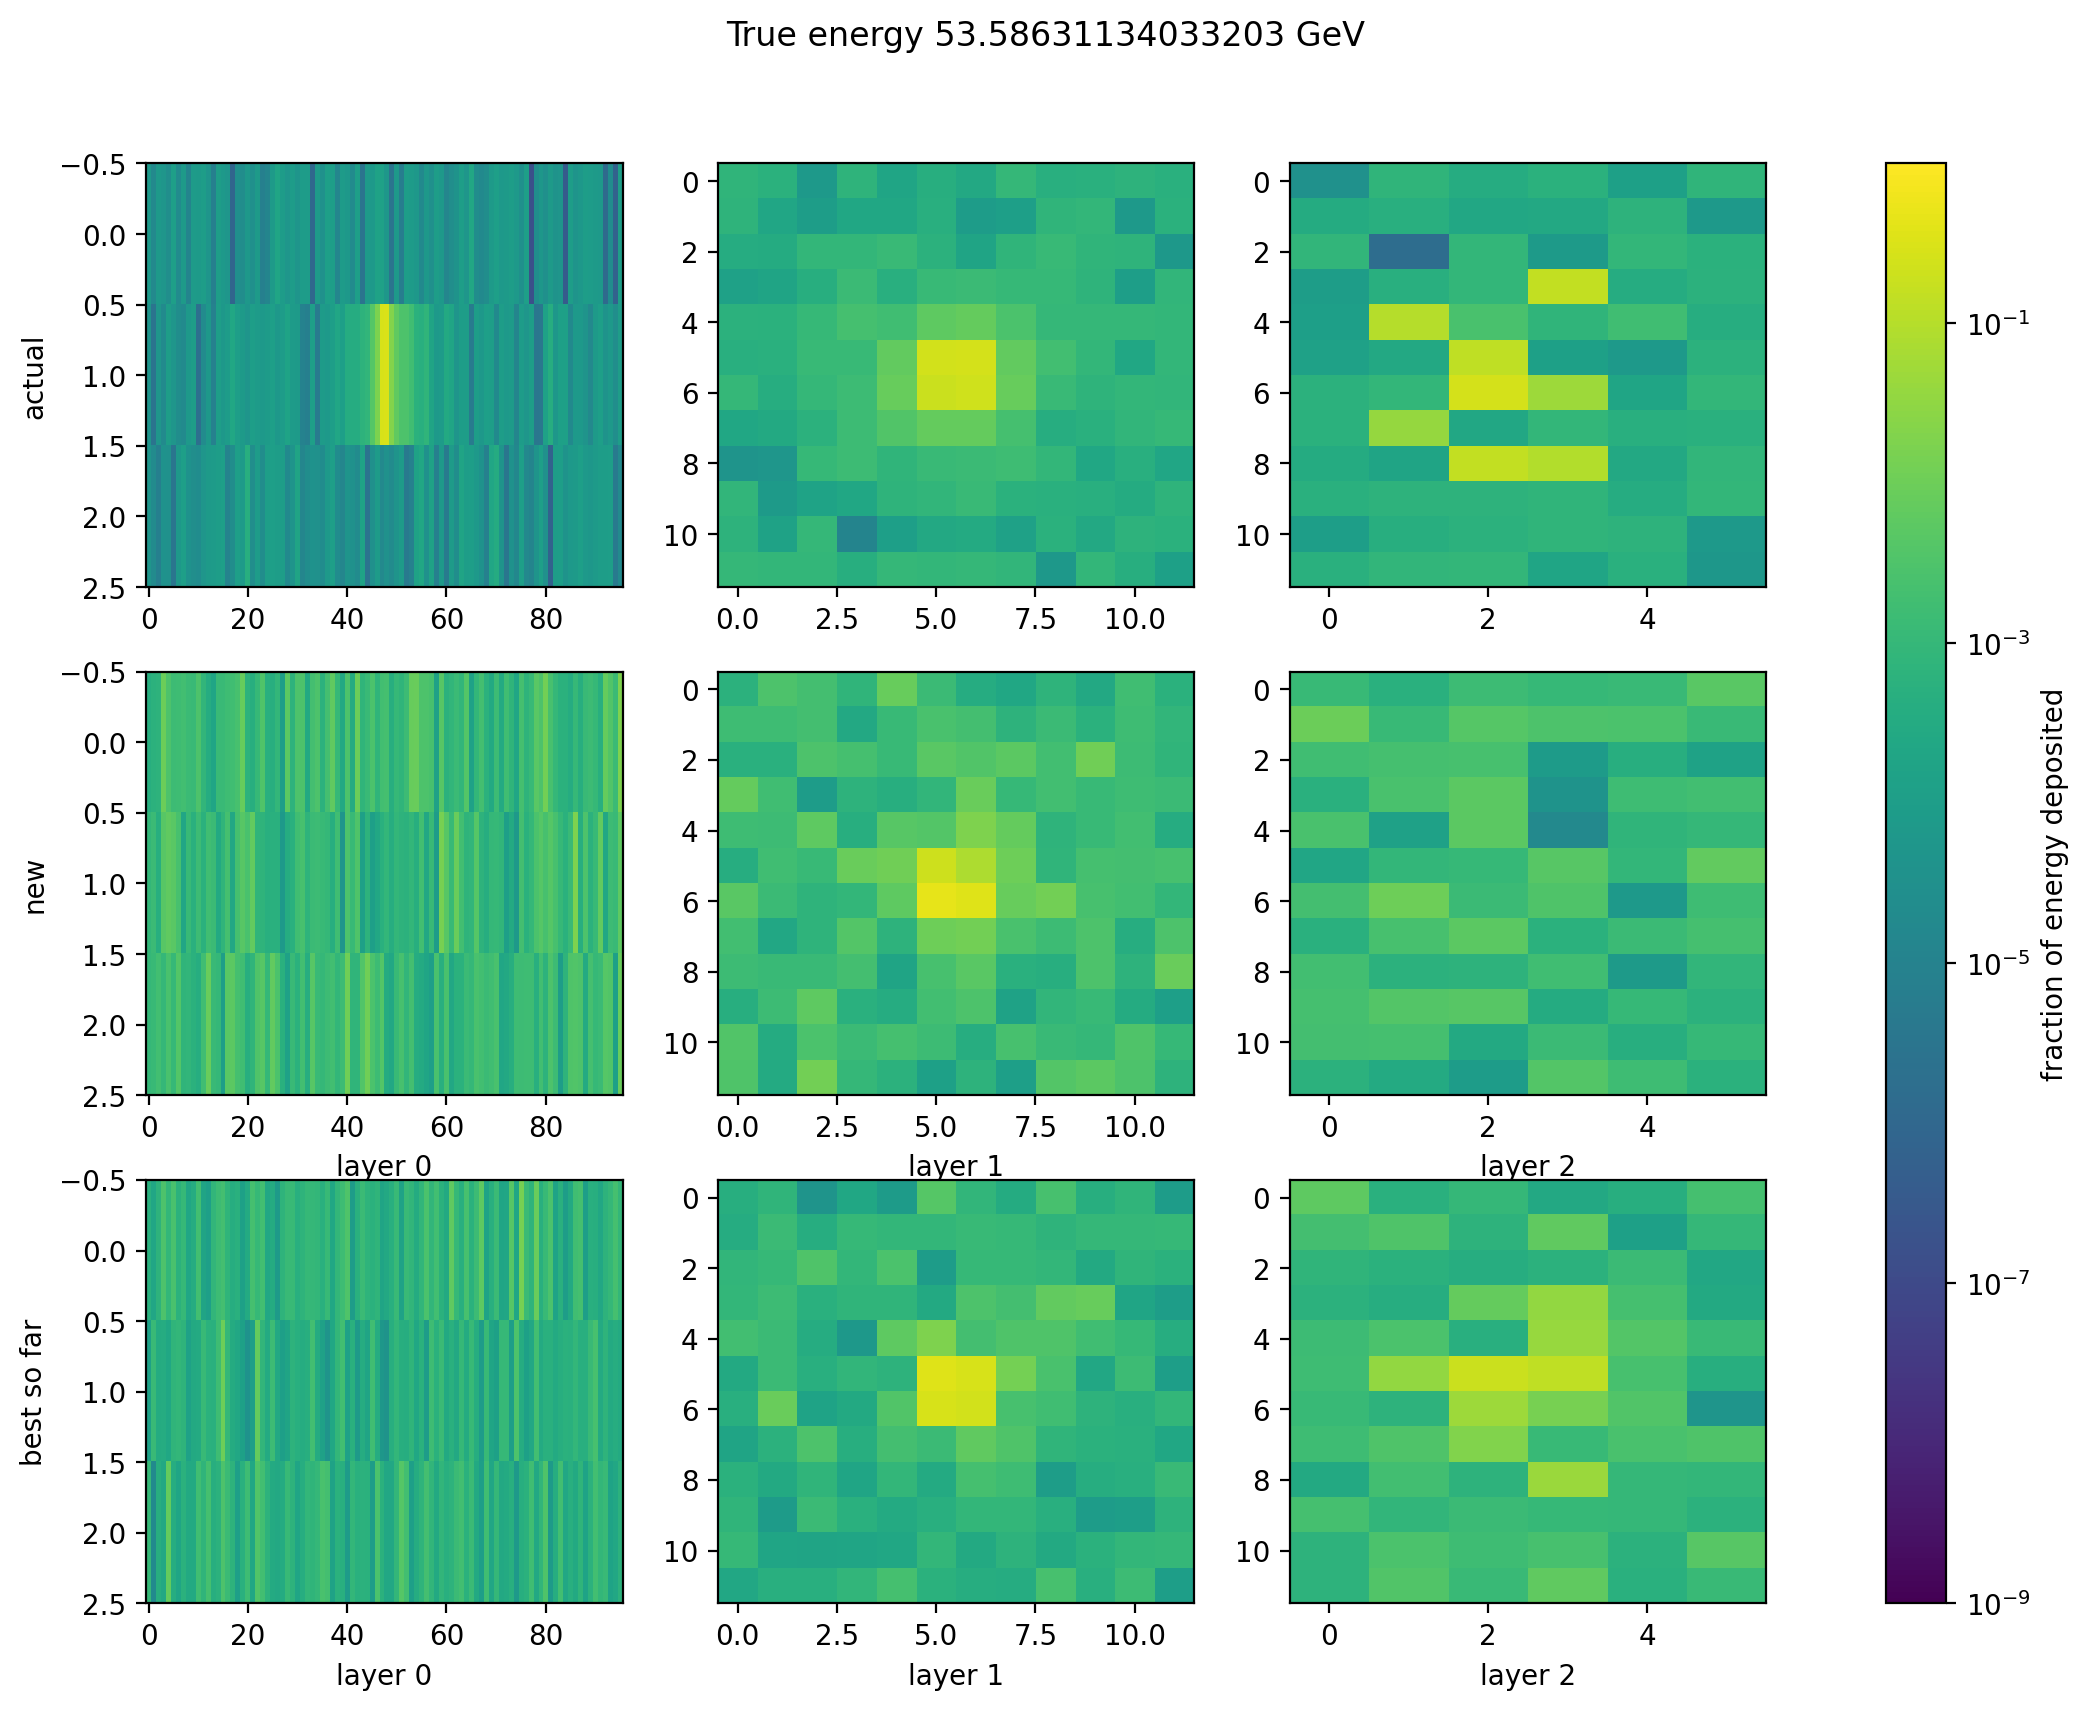

In [29]:
import matplotlib.colors as colors

i = np.random.randint(n)
#i = 28699
#i = 6032

print(f"Showing event number {i}")
fig = plt.figure(figsize=(12,9))
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
plt.subplot(331)
plt.imshow(energy_voxel[i][:288].reshape((3,96)), aspect='auto', norm=colors.LogNorm(1e-9,1))
plt.ylabel("actual")
plt.subplot(332)
plt.imshow(energy_voxel[i][288:432].reshape((12,12)), aspect='auto', norm=colors.LogNorm(1e-9,1))
plt.subplot(333)
plt.imshow(energy_voxel[i][432:].reshape((12,6)), aspect='auto', norm=colors.LogNorm(1e-9,1))
plt.subplot(334)
plt.imshow(voxels_sampled_1[i][:288].reshape((3,96)), aspect='auto', norm=colors.LogNorm(1e-9,1))
plt.ylabel("new")
plt.xlabel("layer 0")
plt.subplot(335)
plt.imshow(voxels_sampled_1[i][288:432].reshape((12,12)), aspect='auto', norm=colors.LogNorm(1e-9,1))
plt.xlabel("layer 1")
plt.subplot(336)
plt.imshow(voxels_sampled_1[i][432:].reshape((12,6)), aspect='auto', norm=colors.LogNorm(1e-9,1))
plt.xlabel("layer 2")
plt.subplot(337)
plt.imshow(voxels_sampled_2[i][:288].reshape((3,96)), aspect='auto', norm=colors.LogNorm(1e-9,1))
plt.ylabel("best so far")
plt.xlabel("layer 0")
plt.subplot(338)
plt.imshow(voxels_sampled_2[i][288:432].reshape((12,12)), aspect='auto', norm=colors.LogNorm(1e-9,1))
plt.xlabel("layer 1")
plt.subplot(339)
plt.imshow(voxels_sampled_2[i][432:].reshape((12,6)), aspect='auto', norm=colors.LogNorm(1e-9,1))
plt.xlabel("layer 2")

plt.suptitle(f"True energy {energy[i][0]} GeV")
cax = plt.axes([0.85, 0.1, 0.025, 0.8])
plt.colorbar(cax=cax)
plt.ylabel("fraction of energy deposited")

In [17]:
print(min(voxels_sampled[28699][:288]))
print(max(voxels_sampled[28699][:288]))
print(np.std(voxels_sampled[28699][:288]))
print(min(energy_voxel[28699][:288]))
print(max(energy_voxel[28699][:288]))
print(np.std(energy_voxel[28699][:288]))
plt.hist(voxels_sampled[28699][:288])
plt.hist(energy_voxel[28699][:288])

NameError: name 'voxels_sampled' is not defined

In [20]:
avg_image = energy_voxel[:n].mean(axis=0)
avg_1 = voxels_sampled_1.mean(axis=0)
avg_2 = voxels_sampled_2.mean(axis=0)

Text(0, 0.5, 'fraction of energy deposited')

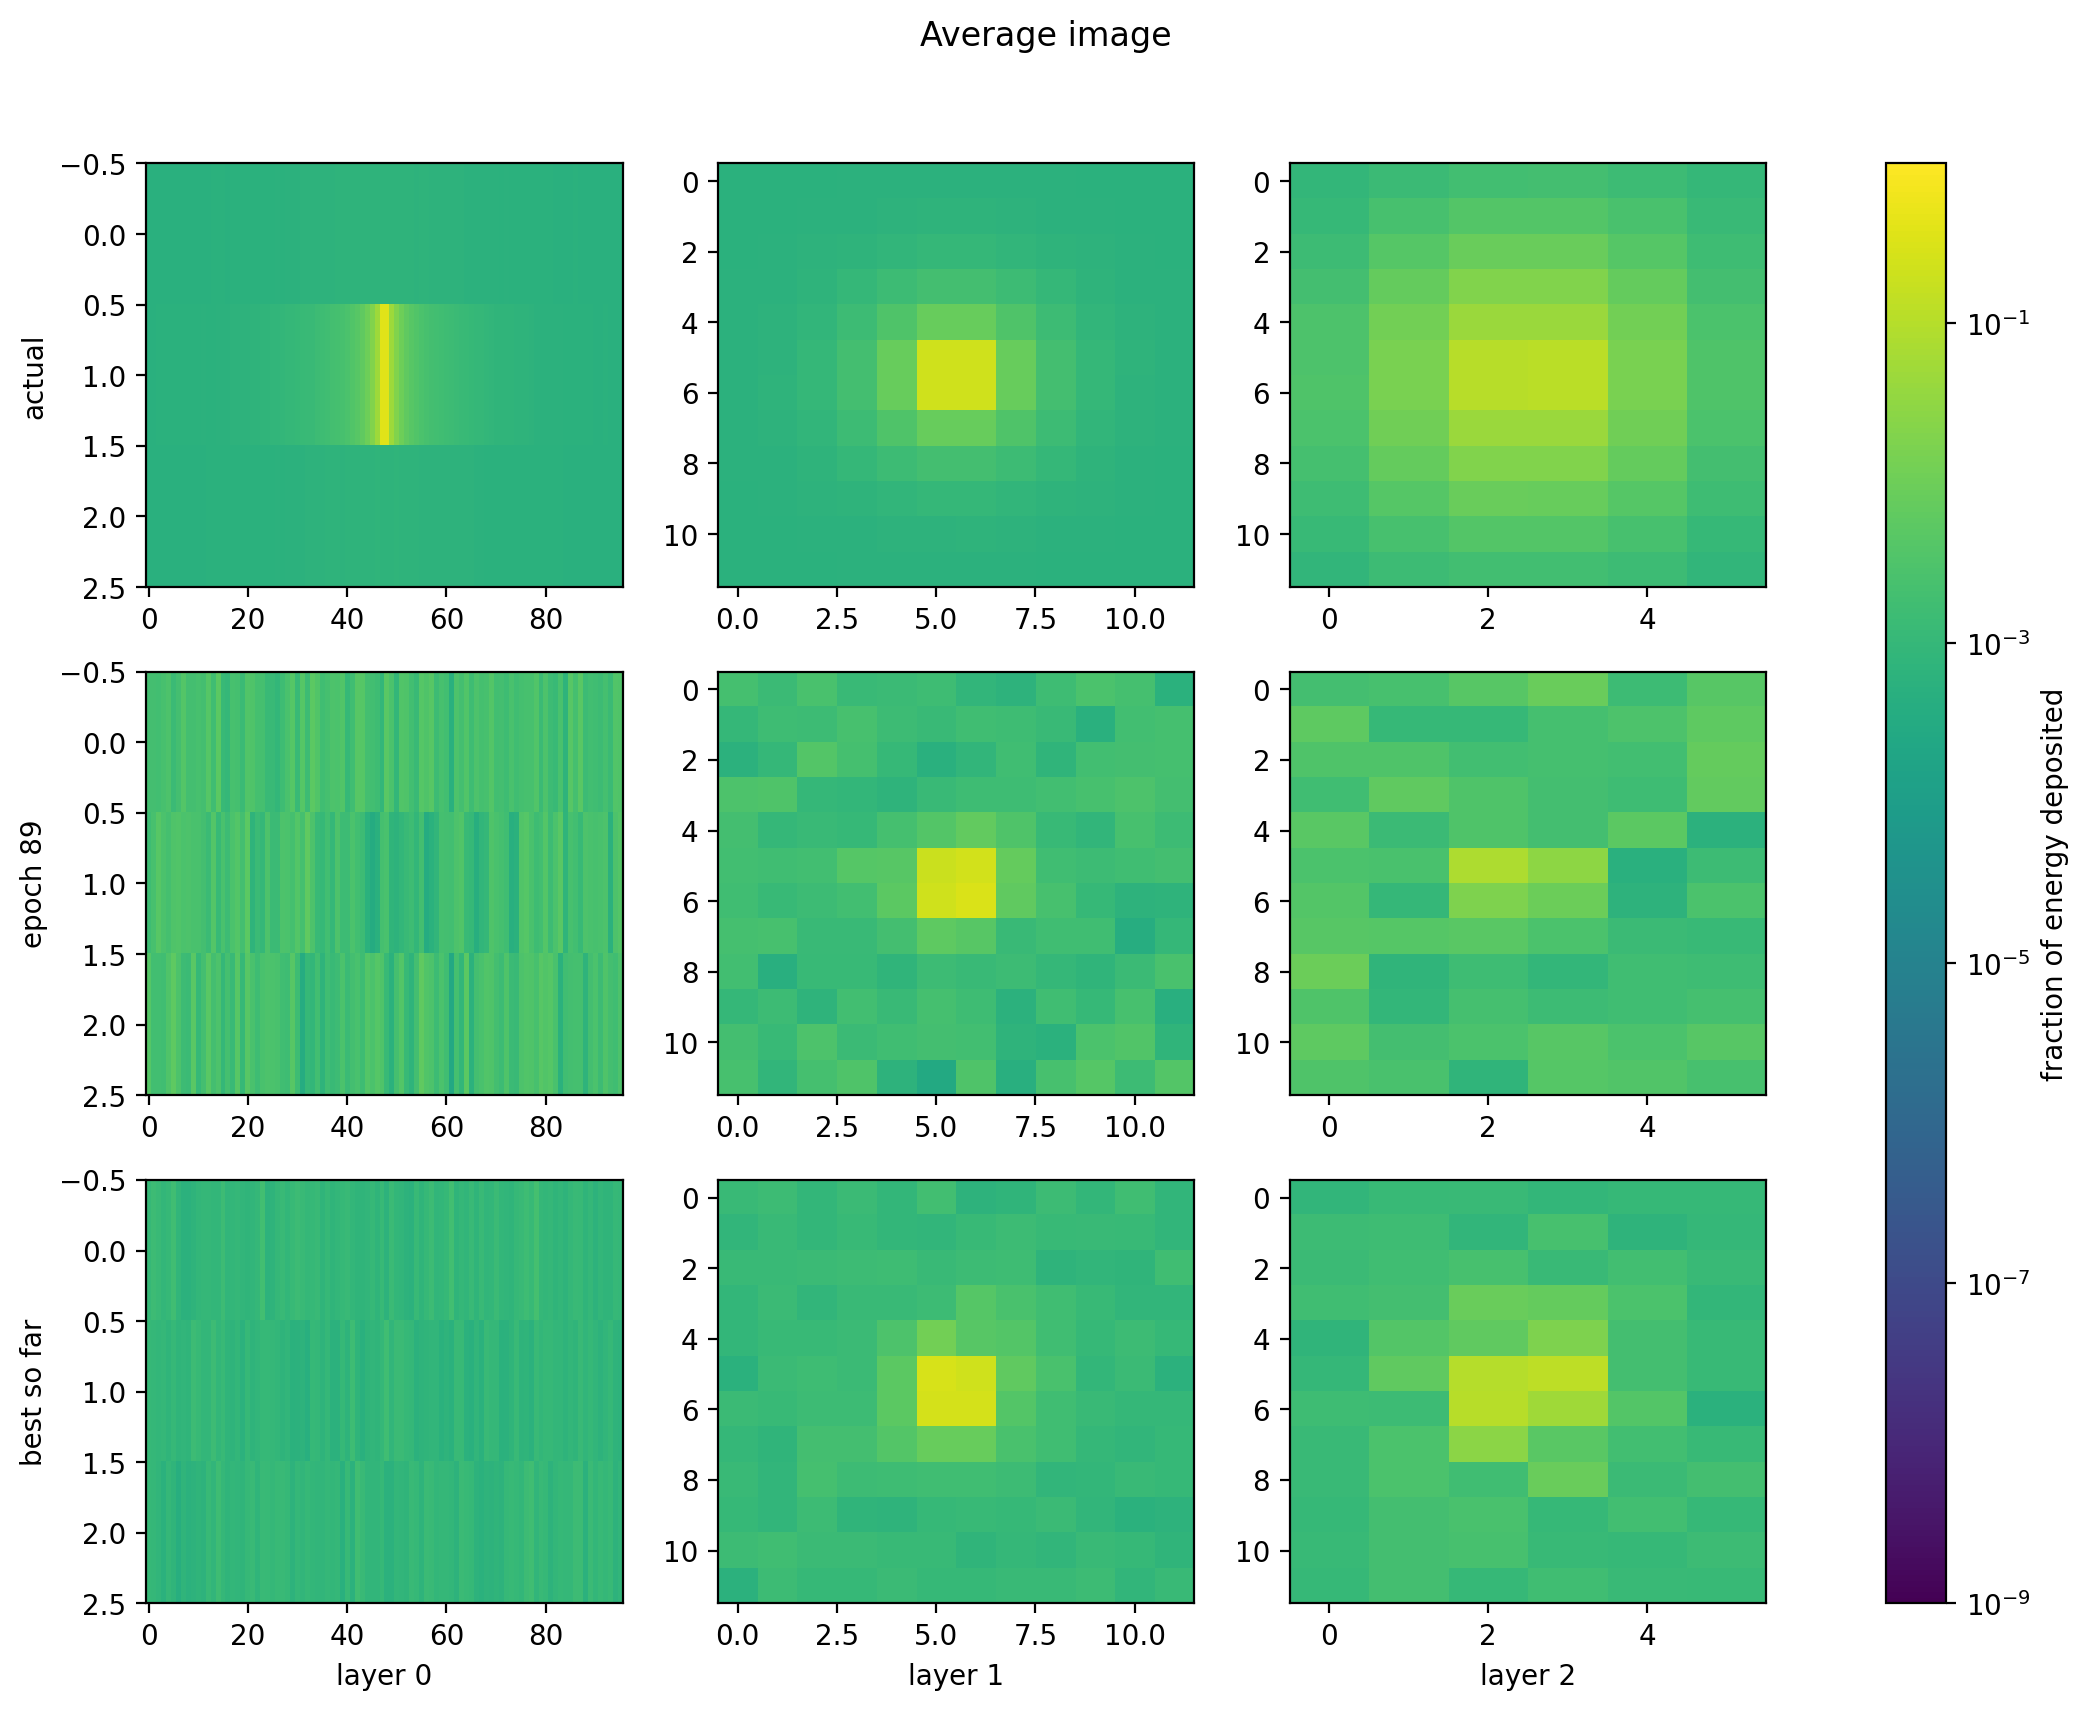

In [21]:
fig = plt.figure(figsize=(12,9))
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
plt.subplot(331)
plt.imshow(avg_image[:288].reshape((3,96)), aspect='auto', norm=colors.LogNorm(1e-9,1))
plt.ylabel("actual")
plt.subplot(332)
plt.imshow(avg_image[288:432].reshape((12,12)), aspect='auto', norm=colors.LogNorm(1e-9,1))
plt.subplot(333)
plt.imshow(avg_image[432:].reshape((12,6)), aspect='auto', norm=colors.LogNorm(1e-9,1))
plt.subplot(334)
plt.imshow(avg_1[:288].reshape((3,96)), aspect='auto', norm=colors.LogNorm(1e-9,1))
plt.ylabel("epoch 89")
#plt.xlabel("layer 0")
plt.subplot(335)
plt.imshow(avg_1[288:432].reshape((12,12)), aspect='auto', norm=colors.LogNorm(1e-9,1))
#plt.xlabel("layer 1")
plt.subplot(336)
plt.imshow(avg_1[432:].reshape((12,6)), aspect='auto', norm=colors.LogNorm(1e-9,1))
#plt.xlabel("layer 2")
plt.subplot(337)
plt.imshow(avg_2[:288].reshape((3,96)), aspect='auto', norm=colors.LogNorm(1e-9,1))
plt.ylabel("best so far")
plt.xlabel("layer 0")
plt.subplot(338)
plt.imshow(avg_2[288:432].reshape((12,12)), aspect='auto', norm=colors.LogNorm(1e-9,1))
plt.xlabel("layer 1")
plt.subplot(339)
plt.imshow(avg_2[432:].reshape((12,6)), aspect='auto', norm=colors.LogNorm(1e-9,1))
plt.xlabel("layer 2")

plt.suptitle("Average image")
cax = plt.axes([0.85, 0.1, 0.025, 0.8])
plt.colorbar(cax=cax)
plt.ylabel("fraction of energy deposited")

/tmp/ipykernel_20860/4095840686.py:23: RuntimeWarning: invalid value encountered in float_scalars
  Eratio2.append((l2[-1] - l2[-2])/(l2[-1] + l2[-2]))
/tmp/ipykernel_20860/4095840686.py:21: RuntimeWarning: invalid value encountered in float_scalars
  Eratio0.append((l0[-1] - l0[-2])/(l0[-1] + l0[-2]))


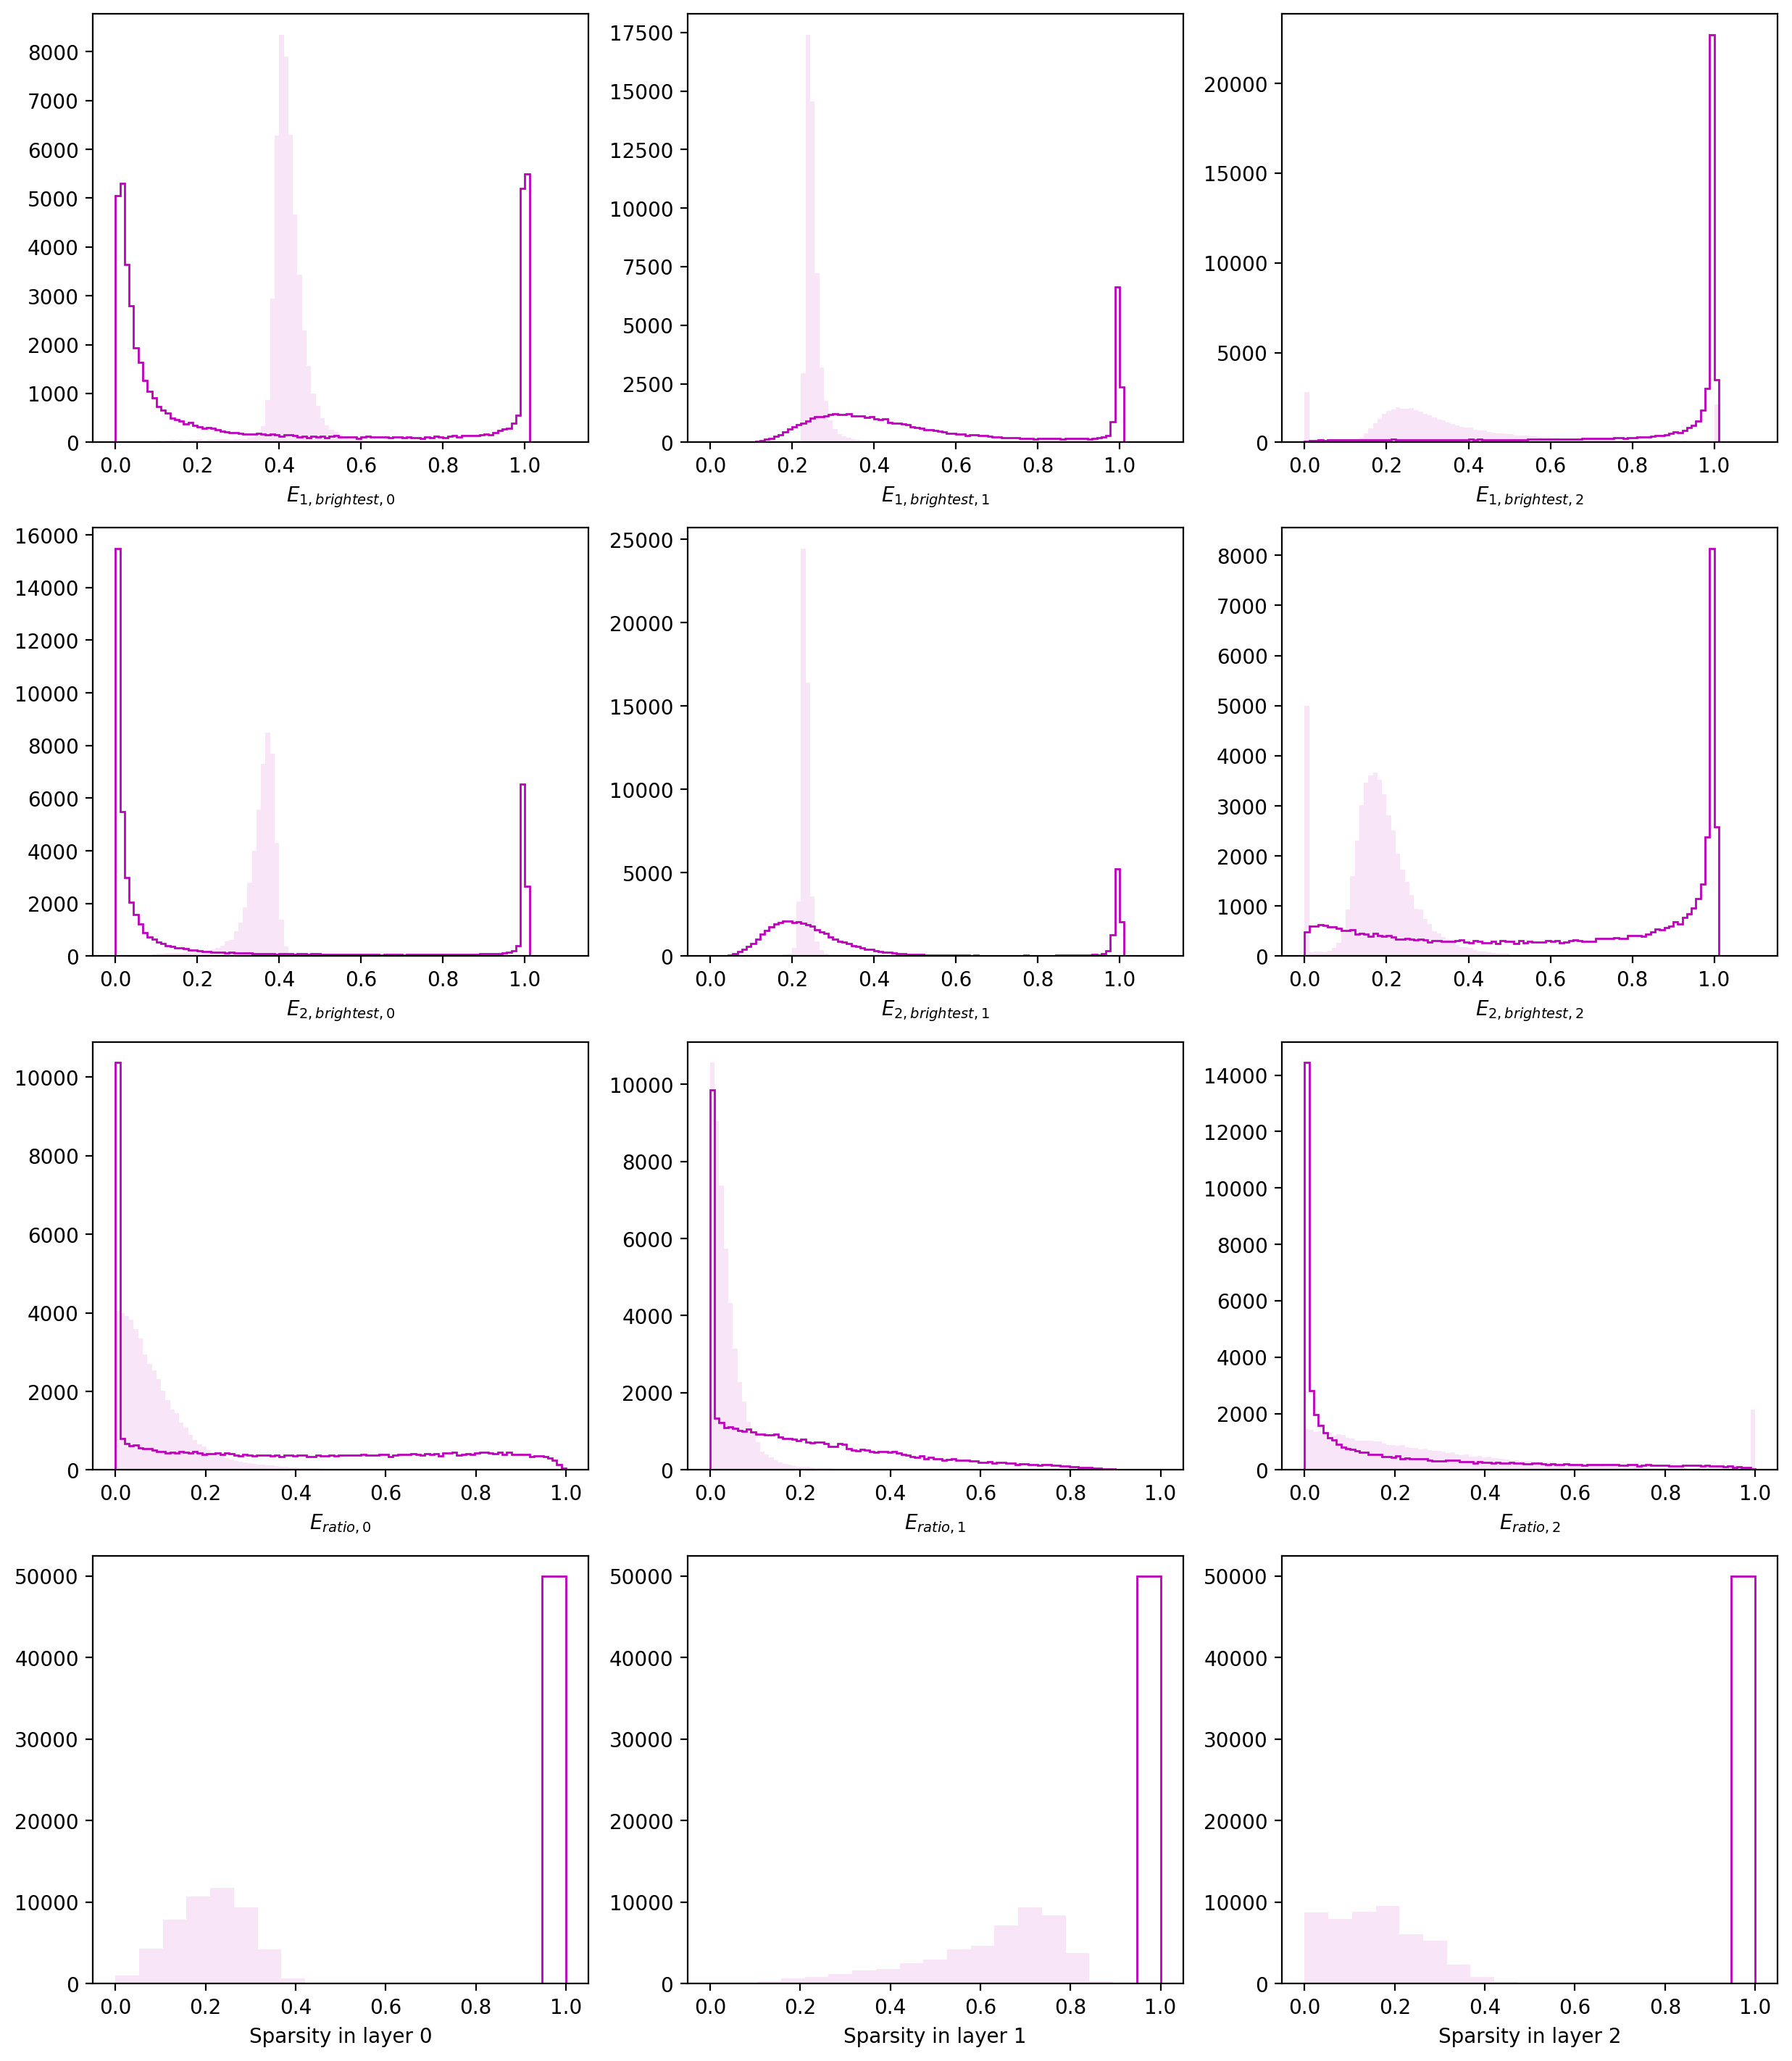

In [38]:
def plot_flow2_hists(energy_voxel, voxels_sampled):
    fig = plt.figure(figsize=(15, 18))
    E1b0, E1b1, E1b2 = [], [], []
    E2b0, E2b1, E2b2 = [], [], []
    E1b0s, E1b1s, E1b2s = [], [], []
    E2b0s, E2b1s, E2b2s = [], [], []
    Eratio0, Eratio1, Eratio2 = [], [], []
    spar0, spar1, spar2 = [], [], []
    Eratio0s, Eratio1s, Eratio2s = [], [], []
    spar0s, spar1s, spar2s = [], [], []
    for voxels in energy_voxel:
        l0 = np.sort(voxels[:288])
        l1 = np.sort(voxels[288:432])
        l2 = np.sort(voxels[432:])
        E1b0.append(l0[-1])
        E1b1.append(l1[-1])
        E1b2.append(l2[-1])
        E2b0.append(l0[-2])
        E2b1.append(l1[-2])
        E2b2.append(l2[-2])
        Eratio0.append((l0[-1] - l0[-2])/(l0[-1] + l0[-2]))
        Eratio1.append((l1[-1] - l1[-2])/(l1[-1] + l1[-2]))
        Eratio2.append((l2[-1] - l2[-2])/(l2[-1] + l2[-2]))
        spar0.append(np.count_nonzero(l0)/288)
        spar1.append(np.count_nonzero(l1)/144)
        spar2.append(np.count_nonzero(l2)/72)
    
    for voxels in voxels_sampled:
        l0 = np.sort(voxels[:288])
        l1 = np.sort(voxels[288:432])
        l2 = np.sort(voxels[432:])
        E1b0s.append(l0[-1])
        E1b1s.append(l1[-1])
        E1b2s.append(l2[-1])
        E2b0s.append(l0[-2])
        E2b1s.append(l1[-2])
        E2b2s.append(l2[-2])
        Eratio0s.append((l0[-1] - l0[-2])/(l0[-1] + l0[-2]))
        Eratio1s.append((l1[-1] - l1[-2])/(l1[-1] + l1[-2]))
        Eratio2s.append((l2[-1] - l2[-2])/(l2[-1] + l2[-2]))
        spar0s.append(np.count_nonzero(l0)/288)
        spar1s.append(np.count_nonzero(l1)/144)
        spar2s.append(np.count_nonzero(l2)/72)
        
    plt.subplot(431)
    #plt.hist(E1b0s)
    plt.hist(E1b0, bins=np.linspace(0,1.1,100), color='m', alpha=0.1)
    plt.hist(E1b0s, bins=np.linspace(0,1.1,100), color='m', histtype='step')
    plt.xlabel("$E_{1,brightest,0}$")
    plt.subplot(432)
    plt.hist(E1b1, bins=np.linspace(0,1.1,100), color='m', alpha=0.1)
    plt.hist(E1b1s, bins=np.linspace(0,1.1,100), color='m', histtype='step')
    plt.xlabel("$E_{1,brightest,1}$")
    plt.subplot(433)
    plt.hist(E1b2, bins=np.linspace(0,1.1,100), color='m', alpha=0.1)
    plt.hist(E1b2s, bins=np.linspace(0,1.1,100), color='m', histtype='step')
    plt.xlabel("$E_{1,brightest,2}$")
    plt.subplot(434)
    plt.hist(E2b0, bins=np.linspace(0,1.1,100), color='m', alpha=0.1)
    plt.hist(E2b0s, bins=np.linspace(0,1.1,100), color='m', histtype='step')
    plt.xlabel("$E_{2,brightest,0}$")
    plt.subplot(435)
    plt.hist(E2b1, bins=np.linspace(0,1.1,100), color='m', alpha=0.1)
    plt.hist(E2b1s, bins=np.linspace(0,1.1,100), color='m', histtype='step')
    plt.xlabel("$E_{2,brightest,1}$")
    plt.subplot(436)
    plt.hist(E2b2, bins=np.linspace(0,1.1,100), color='m', alpha=0.1)
    plt.hist(E2b2s, bins=np.linspace(0,1.1,100), color='m', histtype='step')
    plt.xlabel("$E_{2,brightest,2}$")
    plt.subplot(437)
    plt.hist(Eratio0, bins=np.linspace(0,1,100), color='m', alpha=0.1)
    plt.hist(Eratio0s, bins=np.linspace(0,1,100), color='m', histtype='step')
    plt.xlabel("$E_{ratio,0}$")
    plt.subplot(438)
    plt.hist(Eratio1, bins=np.linspace(0,1,100), color='m', alpha=0.1)
    plt.hist(Eratio1s, bins=np.linspace(0,1,100), color='m', histtype='step')
    plt.xlabel("$E_{ratio,1}$")
    plt.subplot(439)
    plt.hist(Eratio2, bins=np.linspace(0,1,100), color='m', alpha=0.1)
    plt.hist(Eratio2s, bins=np.linspace(0,1,100), color='m', histtype='step')
    plt.xlabel("$E_{ratio,2}$")
    plt.subplot(4,3,10)
    plt.hist(spar0, bins=np.linspace(0,1,20), color='m', alpha=0.1)
    plt.hist(spar0s, bins=np.linspace(0,1,20), color='m', histtype='step')
    plt.xlabel("Sparsity in layer 0")
    plt.subplot(4,3,11)
    plt.hist(spar1, bins=np.linspace(0,1,20), color='m', alpha=0.1)
    plt.hist(spar1s, bins=np.linspace(0,1,20), color='m', histtype='step')
    plt.xlabel("Sparsity in layer 1")
    plt.subplot(4,3,12)
    plt.hist(spar2, bins=np.linspace(0,1,20), color='m', alpha=0.1)
    plt.hist(spar2s, bins=np.linspace(0,1,20), color='m', histtype='step')
    plt.xlabel("Sparsity in layer 2")

plot_flow2_hists(energy_voxel[:n], voxels_sampled)
#plot_flow2_hists(voxels_sampled, voxels_sampled_222)

/tmp/ipykernel_20860/4095840686.py:23: RuntimeWarning: invalid value encountered in float_scalars
  Eratio2.append((l2[-1] - l2[-2])/(l2[-1] + l2[-2]))
/tmp/ipykernel_20860/4095840686.py:21: RuntimeWarning: invalid value encountered in float_scalars
  Eratio0.append((l0[-1] - l0[-2])/(l0[-1] + l0[-2]))


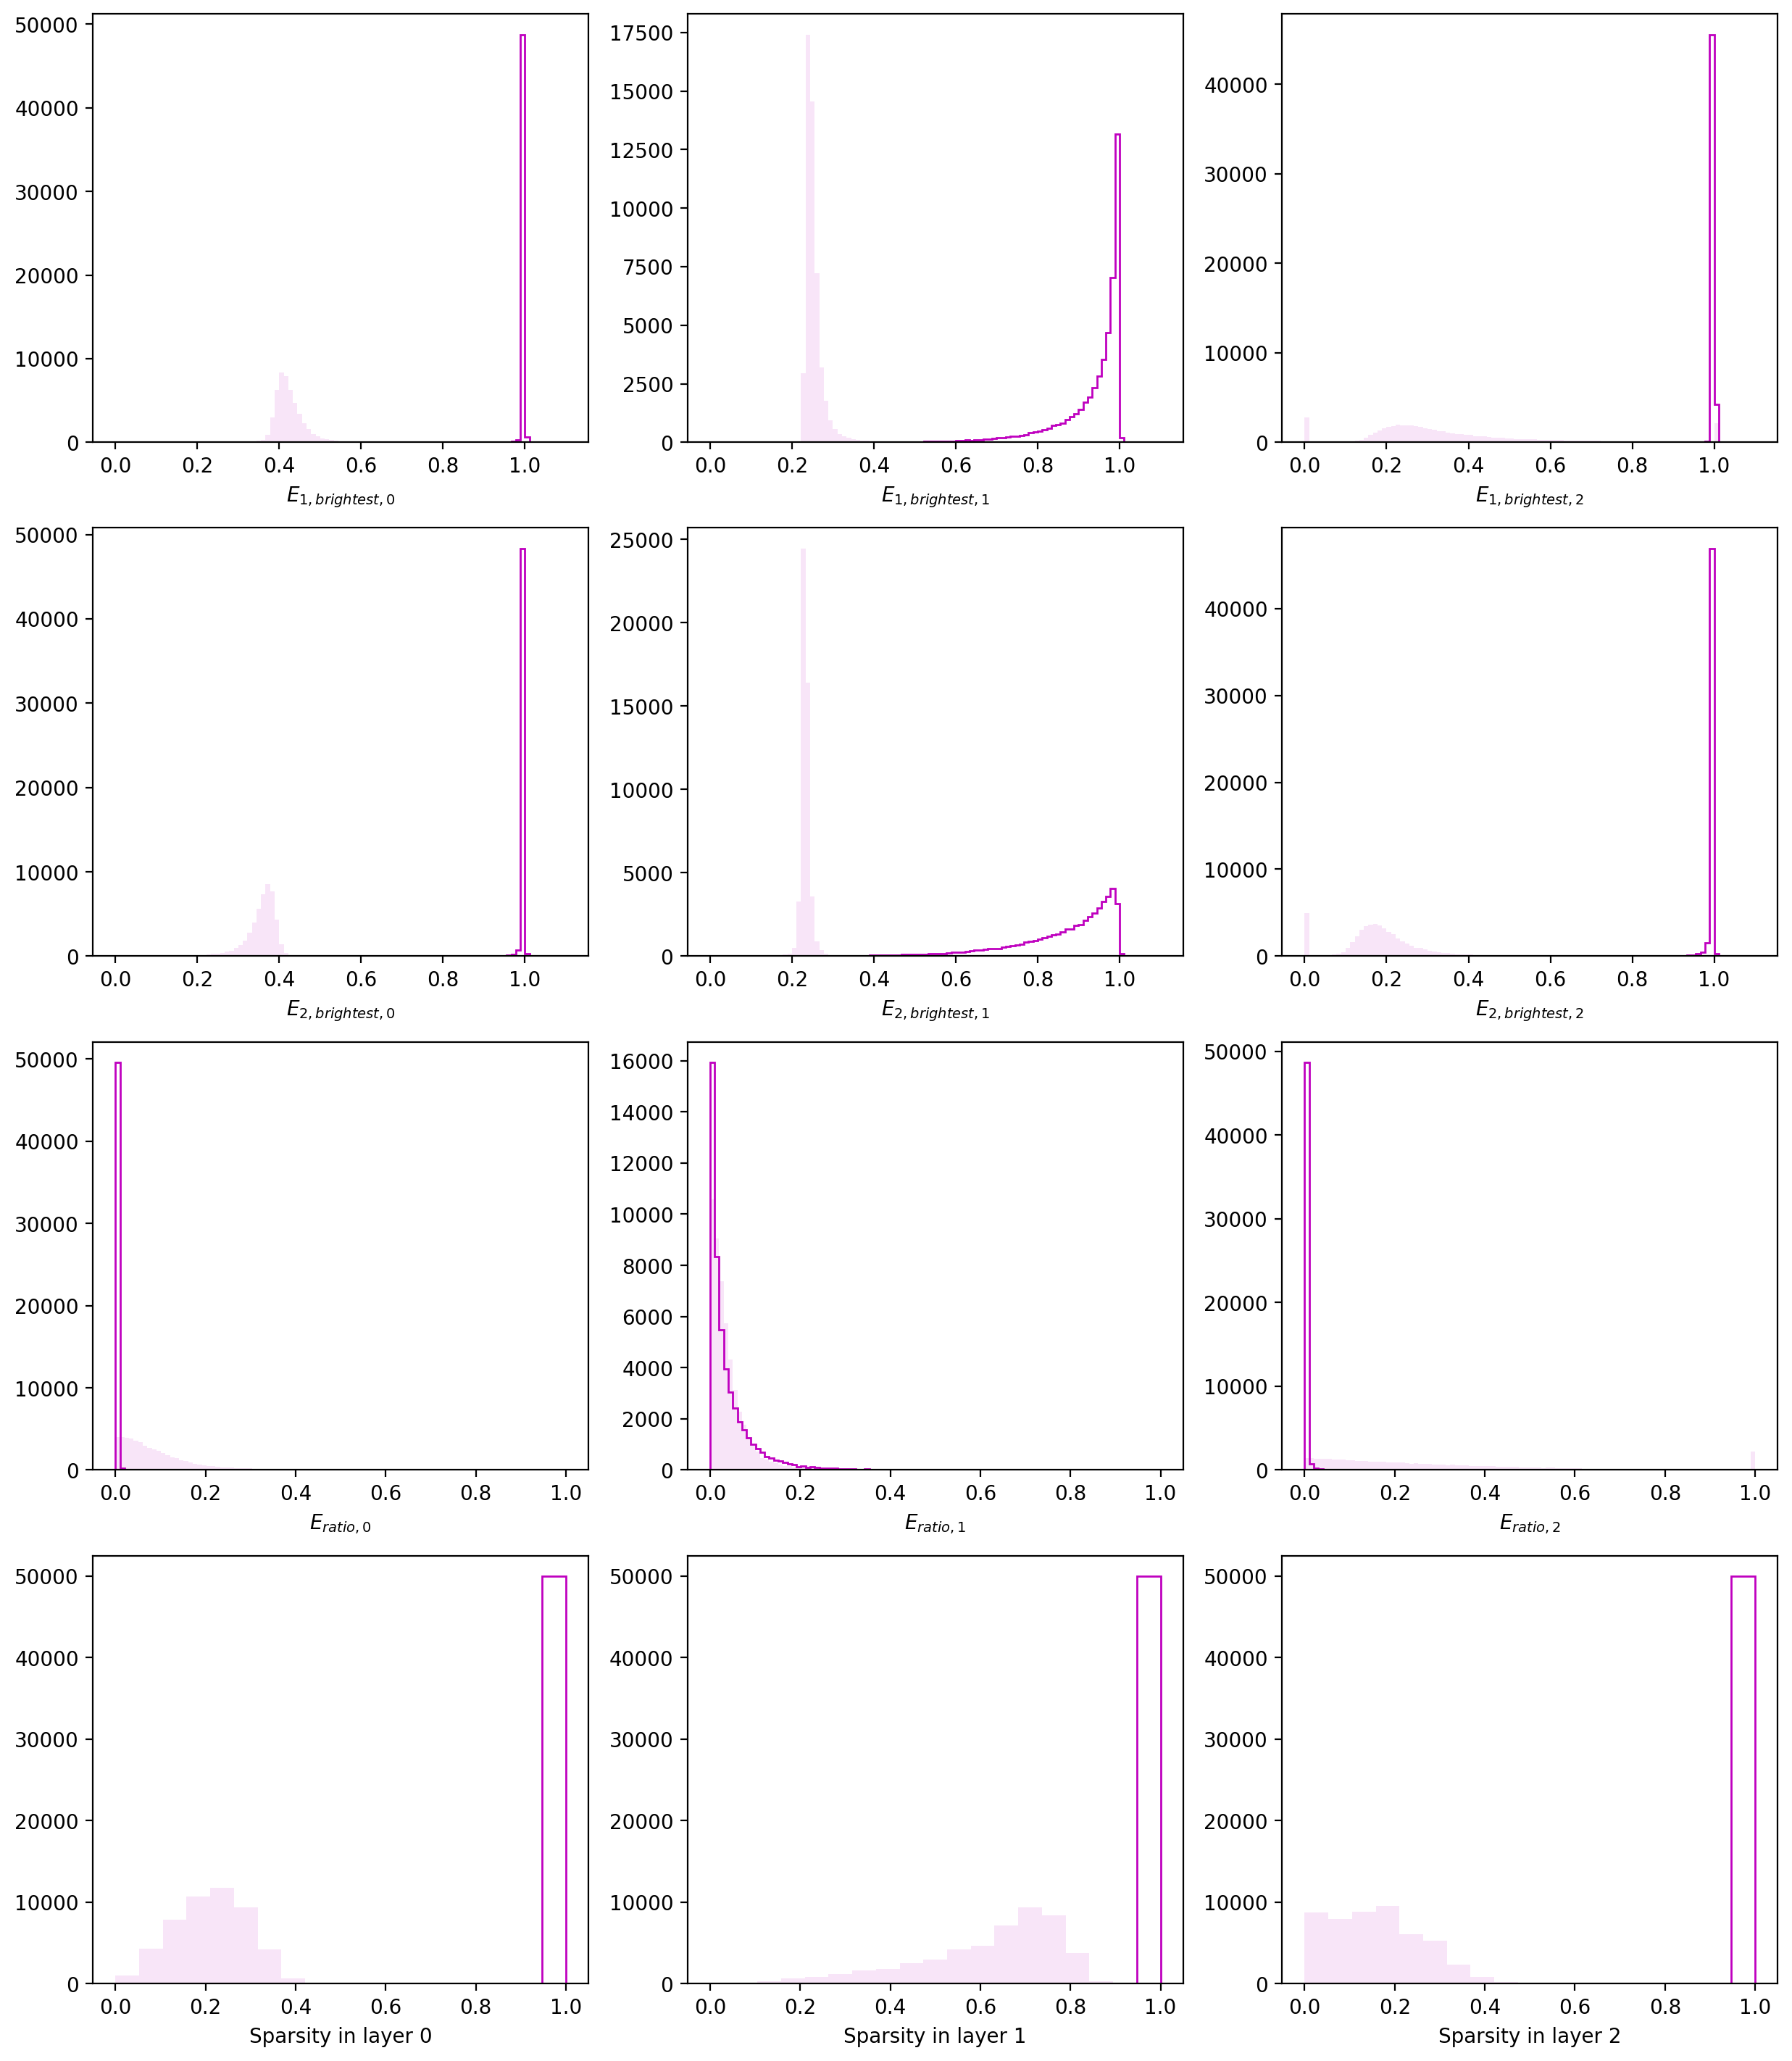

In [39]:
plot_flow2_hists(energy_voxel[:n], voxels_sampled_222)

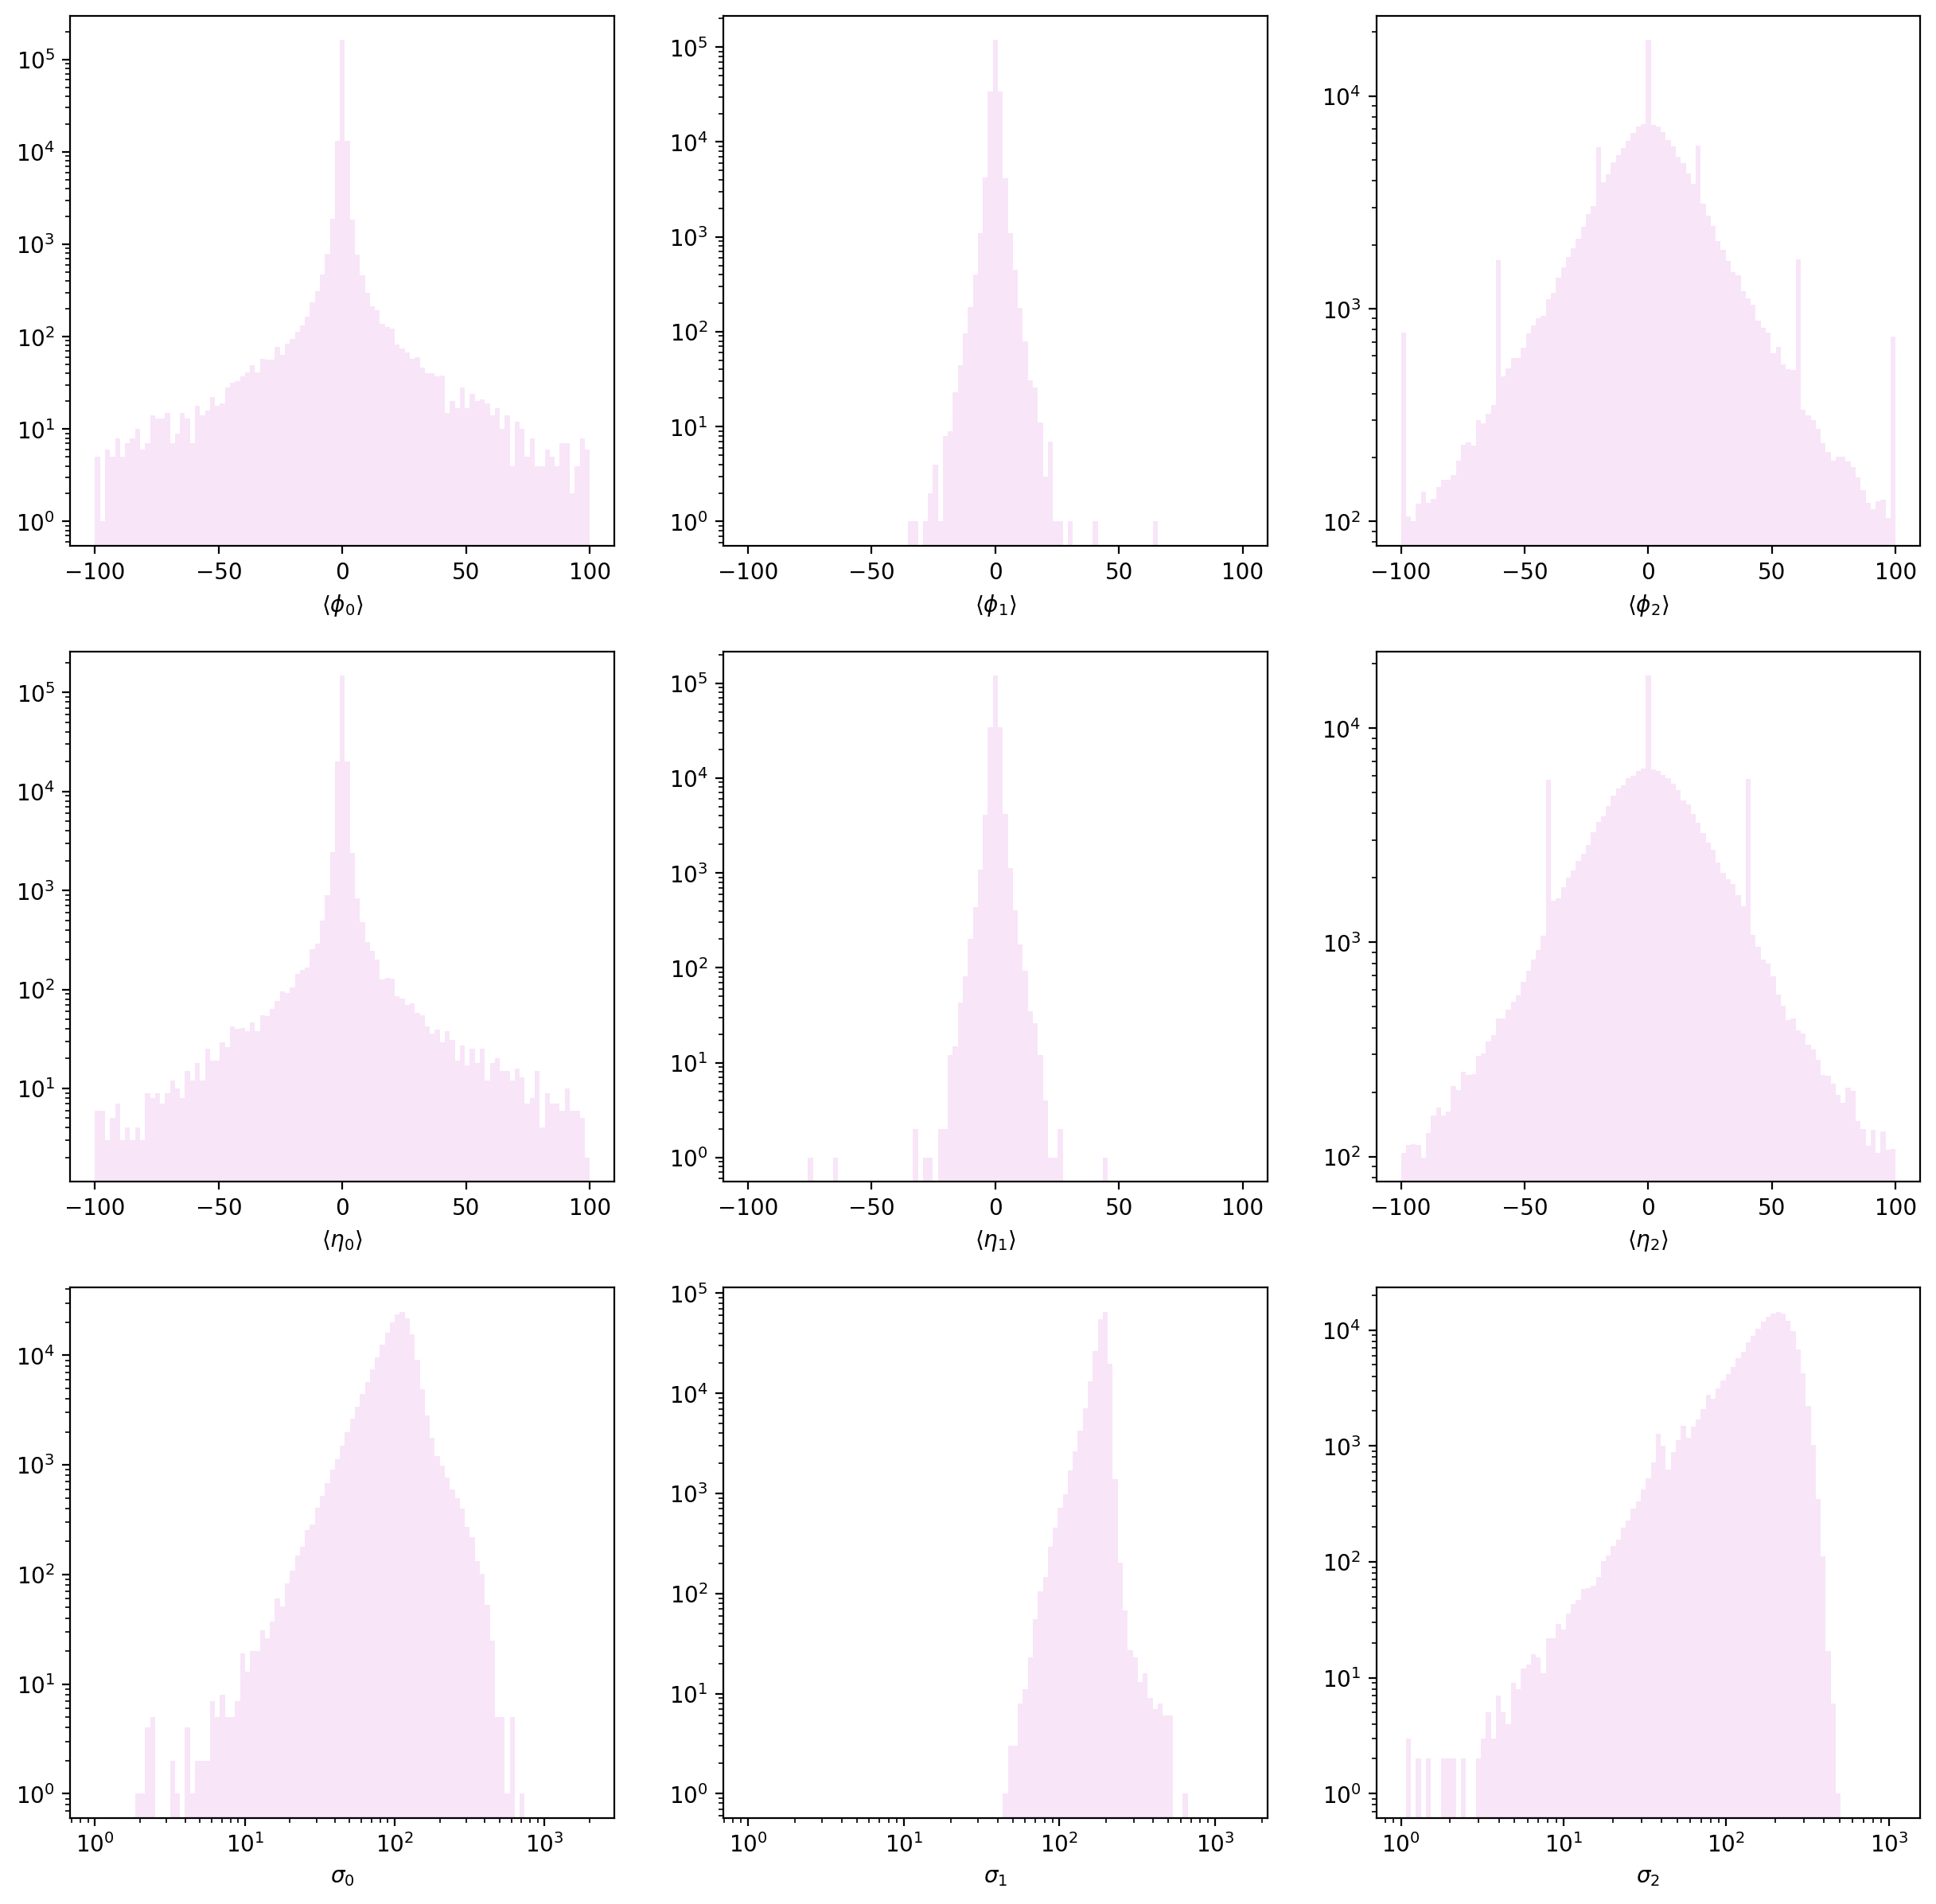

In [232]:
def plot_flow2_shape_hists(energy_voxel):
    fig = plt.figure(figsize=(15, 15))
    H0 = np.full((3, 96), np.linspace(0,475,96)+2.5).flatten() - 240.0
    H1 = np.full((12, 12), np.linspace(0,440,12)+20.0).flatten() - 240.0
    H2 = np.full((12, 6), np.linspace(0,400,6)+40.0).flatten() - 240.0
    F0 = np.full((96, 3), np.linspace(0,320,3)+80.0).T.flatten() - 240.0
    F1 = np.full((12, 12), np.linspace(0,440,12)+20.0).T.flatten() - 240.0
    F2 = np.full((6, 12), np.linspace(0,440,12)+20.0).T.flatten() - 240.0
    eta0, eta1, eta2 = [], [], []
    phi0, phi1, phi2 = [], [], []
    sigma0, sigma1, sigma2 = [], [], []
    for voxels in energy_voxel:
        l0 = voxels[:288]
        l1 = voxels[288:432]
        l2 = voxels[432:]
        eta0.append(sum(l0*H0))
        eta1.append(sum(l1*H1))
        eta2.append(sum(l2*H2))
        phi0.append(sum(l0*F0))
        phi1.append(sum(l1*F1))
        phi2.append(sum(l2*F2))
        sigma0.append(sum(np.sqrt(l0 * H0**2 - (l0*H0)**2)))
        sigma1.append(sum(np.sqrt(l1 * H1**2 - (l1*H1)**2)))
        sigma2.append(sum(np.sqrt(l2 * H2**2 - (l2*H2)**2)))
    
    plt.subplot(331)
    plt.hist(phi0, bins=np.linspace(-100,100,100), color='m', alpha=0.1, log=True)
    plt.xlabel(r'$\langle\phi_0\rangle$')
    plt.subplot(332)
    plt.hist(phi1, bins=np.linspace(-100,100,100), color='m', alpha=0.1, log=True)
    plt.xlabel(r'$\langle\phi_1\rangle$')
    plt.subplot(333)
    plt.hist(phi2, bins=np.linspace(-100,100,100), color='m', alpha=0.1, log=True)
    plt.xlabel(r'$\langle\phi_2\rangle$')
    plt.subplot(334)
    plt.hist(eta0, bins=np.linspace(-100,100,100), color='m', alpha=0.1, log=True)
    plt.xlabel(r'$\langle\eta_0\rangle$')
    plt.subplot(335)
    plt.hist(eta1, bins=np.linspace(-100,100,100), color='m', alpha=0.1, log=True)
    plt.xlabel(r'$\langle\eta_1\rangle$')
    plt.subplot(336)
    plt.hist(eta2, bins=np.linspace(-100,100,100), color='m', alpha=0.1, log=True)
    plt.xlabel(r'$\langle\eta_2\rangle$')
    plt.subplot(337)
    plt.hist(sigma0, bins=np.geomspace(1,2000,100), color='m', alpha=0.1, log=True)
    plt.xlabel(r'$\sigma_0$')
    plt.xscale('log')
    plt.subplot(338)
    plt.hist(sigma1, bins=np.geomspace(1,1500,100), color='m', alpha=0.1, log=True)
    plt.xlabel(r'$\sigma_1$')
    plt.xscale('log')
    plt.subplot(339)
    plt.hist(sigma2, bins=np.geomspace(1,1100,100), color='m', alpha=0.1, log=True)
    plt.xlabel(r'$\sigma_2$')
    plt.xscale('log')

plot_flow2_shape_hists(energy_voxel)

In [48]:
%%time

events = np.random.randint(200000, size=100)
points, conds = [], []
for i in events:
    points.append(data_flow2[i][:504].astype(np.float32))
    conds.append(data_flow2[i][504:])
points = np.array(points)
conds = np.array(conds)
logp121 = model121.conditional_log_prob(points, conds).numpy()
logp122 = model122.conditional_log_prob(points, conds).numpy()

CPU times: user 1.58 s, sys: 174 ms, total: 1.76 s
Wall time: 956 ms


(array([ 1.,  0.,  2.,  8., 15., 28., 26., 16.,  2.,  2.]),
 array([-1270.7758 , -1208.5767 , -1146.3777 , -1084.1786 , -1021.9795 ,
         -959.78046,  -897.5814 ,  -835.3823 ,  -773.1833 ,  -710.9842 ,
         -648.78516], dtype=float32),
 <BarContainer object of 10 artists>)

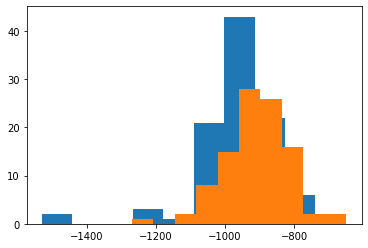

In [49]:
plt.hist(logp121)
plt.hist(logp122)

In [ ]:
def plot_likelihood(model, unscaled_point, N, alpha):
    e0, e1, e2 = unscaled_point
    etots = np.linspace(1000, 100000, N)
    zs = np.log10(etots/10000).reshape((N,1))
    points, jacs = [], []
    for z in zs:
        etot = 10 ** z[0] * 10
        data = preprocess_caloflow(1, np.array([e0]), np.array([e1]), np.array([e2]), np.array([[etot]]), alpha)
        v0, v1, v2 = data[0][0], data[0][1], data[0][2]
        en = np.array([v0, v1, v2])
        points.append(en)
        jac = jacobian(v0, v1, v2, etot*1000, alpha)
        jacs.append(jac)
    points = np.array(points).astype(np.float32)
    log_probs = model.conditional_log_prob(points, zs)
    actual_log_probs = np.array(log_probs) - np.log(np.array(jacs))
    #print(jacs)
    fig = plt.figure(figsize=(15,5))
    plt.subplot(131)
    plt.plot(10**zs*10000, log_probs)
    plt.title("log p(v|Etot)")
    plt.subplot(132)
    plt.plot(10**zs*10000, np.log(jacs))
    plt.title("log Jacobian")
    plt.subplot(133)
    plt.plot(10**zs*10000, actual_log_probs)
    plt.title("log p(E|Etot)")
    #fig.supxlabel("Etot (MeV)")

#i = 2048
i = np.random.randint(200000)
e0, e1, e2 = layer0[i], layer1[i], layer2[i]
en = np.array([e0, e1, e2])
plot_likelihood(model, en, 100, alpha)